# Creating ARMA model on Daily Total Female Births

## Importing Libraries

In [1]:
#Importing libraries for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Importing libraries for stop warnings
import warnings
warnings.filterwarnings('ignore')

#Importing libraries for time series analysis and forecasting
from pmdarima import auto_arima #Auto ARIMA
from statsmodels.tsa.stattools import adfuller #Dicky Fuller Test
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults #ARMA & ARIMA Model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #ACF & PACF Plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tools.eval_measures import rmse

## Loading Data

In [6]:
#Loading data1
data1 = pd.read_csv('C:/Users/bhavi/OneDrive/Desktop/Data/Time_Series_Data/DailyTotalFemaleBirths.csv', index_col='Date', parse_dates=True)
data1.index.freq = 'D'

In [11]:
#Checking data
data1

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44
...,...
1959-12-27,37
1959-12-28,52
1959-12-29,48


Observations:
- Data consist of 365 days

## Visualizing the data

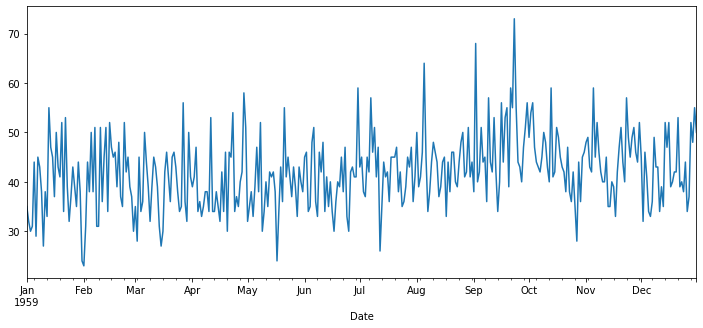

In [9]:
#Creating Plot on data1
data1['Births'].plot(figsize = (12,5));

Observations:
- It looks stationary.We much perform dicky fuller test for futher clarification.
- There is no trend and seasonality observed. We must do seaconal decomposition of the data.

## Checking stationarity through dicky fuller test

In [55]:
#Creating function which extract the summary of the dicky fuller test and final conclusion
def DICKY_FULLER_TEST(data):
    result = adfuller(data)
    critical_value = result[0]
    p_value = result[1]
    lags = result[2]
    observation = result[3]
    cv = []
    print('Dicky Fuller Test Summary:')
    print('1. ADFT Statistics:',critical_value)
    print('2. P-value        :',p_value)
    print('3. Lags           :',lags)
    print('4. Observations   :',observation)
    print('5. Critical Values:')
    for i,j in result[4].items():
        cv.append(j)
        print('                  ',i,'=>',j)
    print('6.Test conclusion from p-value :')
    if p_value<0.05:
        print('  It is a stationary')
    else:
        print('  It is not a stationary')
    print('7.Test conclusion from critical value :')
    if (critical_value<cv[0]) & (critical_value<cv[1]) & (critical_value<cv[2]):
        print('  It is a stationary')
    else:
        print('  It is not a stationary')
        
DICKY_FULLER_TEST(data1['Births'])

Dicky Fuller Test Summary:
1. ADFT Statistics: -4.808291253559763
2. P-value        : 5.243412990149865e-05
3. Lags           : 6
4. Observations   : 358
5. Critical Values:
                   1% => -3.448748905151901
                   5% => -2.8696473721448728
                   10% => -2.5710891239349585
6.Test conclusion from p-value :
  It is a stationary
7.Test conclusion from critical value :
  It is a stationary


Observation:
- As per the dicky fuller test, We conclude that the data is a stationary.

## Seasonal decomposition of the data

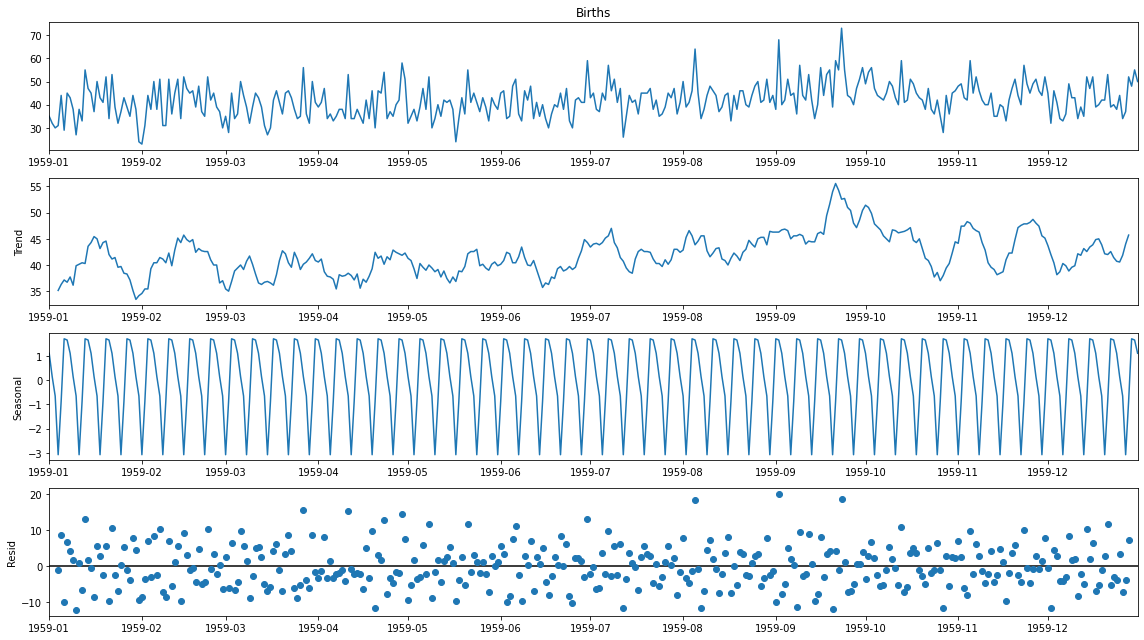

In [12]:
#Decompose the data
decompose = seasonal_decompose(data1['Births'], model = 'add')
plt.rcParams["figure.figsize"] = (16, 9)
decompose.plot();

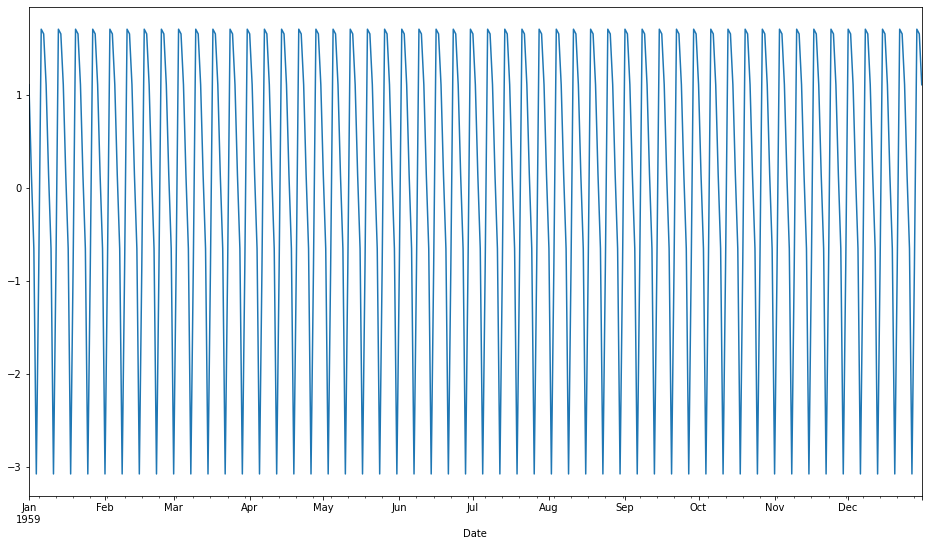

In [6]:
#Creating seasonality plot
decompose.seasonal.plot();

Observation:
- As per the decomposition plot, There is no trend in the data.
- It has a seasonality on weekwise.

## Identifying Order of AR & MA through ACF & PACF Plot

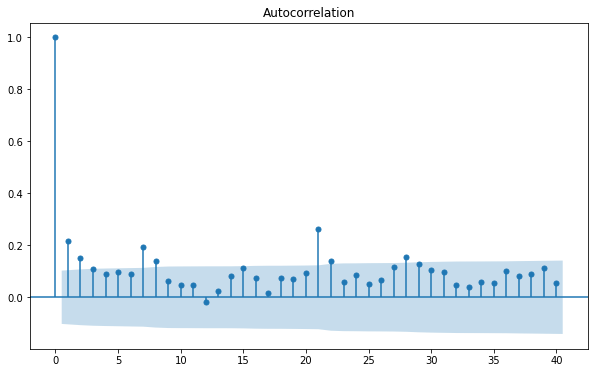

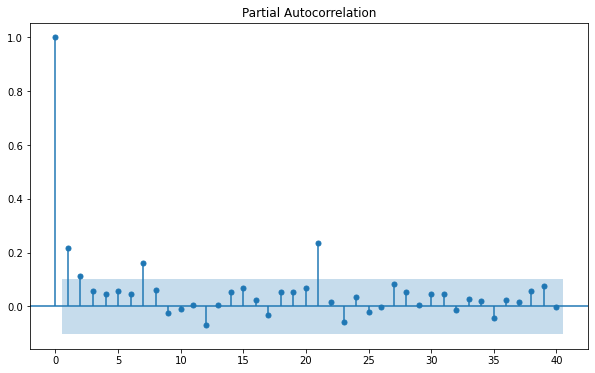

In [17]:
#Creating ACF for finding order for MA
plt.rcParams["figure.figsize"] = (10,6)
plot_acf(data1['Births'], lags=40);

#Creating PACS
plot_pacf(data1['Births'], lags=40);

Observation:
- As per the PACF plot, for AR term it has 2 significant order.
- AS per the ACF plot, for MA term it has 2 significant order.

## Identifying Order of AR & MA through Auto ARIMA

In [20]:
#Performing Auto ARIMA
auto_arima(data1['Births'],
           suppress_warnings=True,
           seasonal=False,
           stationary=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1231.963
Date:                Mon, 29 Mar 2021   AIC                           2471.925
Time:                        18:28:29   BIC                           2487.525
Sample:                             0   HQIC                          2478.125
                                - 365                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.4693      4.940      1.917      0.055      -0.212      19.151
ar.L1          0.7730      0.118      6.531      0.000       0.541       1.005
ma.L1         -0.6100      0.151     -4.028      0.000      -0.907      -0.313
sigma2        50.6199      3.670     13.793      0.000      43.427      57.813
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                18.68
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.48
Prob(H) (two-sided):                  0.81   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Observation:
As per the Auto ARIMA, It is showing (AR-1,MA-1) order.

## Splitting data into train and test

In [21]:
#Checking the size of the data
data1.shape

(365, 1)

In [23]:
#Splitting data into train-80% and test 20%
train = data1.iloc[:292]
test = data1.iloc[292:]
train.shape, test.shape

((292, 1), (73, 1))

## Creating ARMA Model with AR=1 & MA=1 order and Predicting on test data

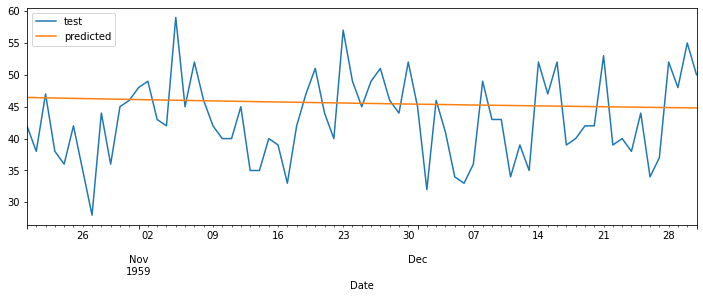

In [42]:
#Creating ARIMA Model
ARMA_model = ARMA(train['Births'], order=(1,1))
ARMA_result = ARMA_model.fit()

#Prediction on the model
ARMA_pred = ARMA_result.predict(start = len(train), end = len(train)+len(test)-1, typ = 'levels')

#Plotting Actual vs Prediction
test['Births'].plot(figsize=(12,4),label='test',legend = True);
ARMA_pred.plot(label = 'predicted',legend = True);

## Creating ARMA Model with AR=2 & MA=2 order and Predicting on test data

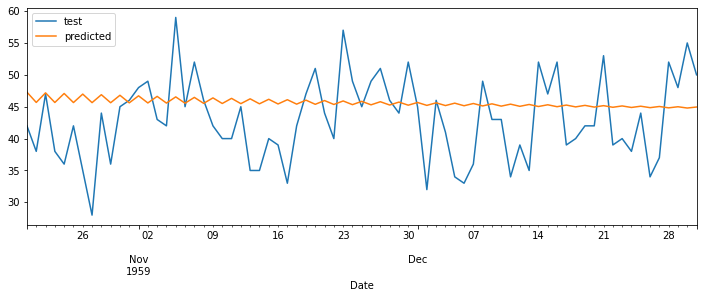

In [43]:
#Creating ARIMA Model with AR=2 & MA=2
ARMA_model2 = ARMA(train['Births'], order=(2,2))
ARMA_result2 = ARMA_model2.fit()

#Prediction on the model
ARMA_pred2 = ARMA_result2.predict(start = len(train), end = len(train)+len(test)-1)

#Plotting Actual vs Prediction
test['Births'].plot(figsize=(12,4),label='test',legend = True);
ARMA_pred2.plot(label = 'predicted',legend = True);

## Evaluation on the model1 & model2

In [44]:
#Computing RMSE
print('RMSE of Model 1:',rmse(test['Births'], ARMA_pred))
print('RMSE of Model 2:',rmse(test['Births'], ARMA_pred2))
print('Mean of Test Data:', test['Births'].mean())

RMSE of Model 1: 6.971012730536744
RMSE of Model 2: 6.960445341342059
Mean of Test Data: 43.02739726027397


## Experiementing the different order combination and checking result

In [45]:
#Experiementing the different order combination and checking result
ARMA_combinations = [(0,1),(1,0),(1,1),(2,1),(2,2),(3,1),(3,2),(3,3)]

for c in ARMA_combinations:
    ARMA_model = ARMA(train['Births'], c)
    ARMA_result = ARMA_model.fit()
    ARMA_pred = ARMA_result.predict(start = len(train), end = len(train)+len(test)-1)
    RMSE = rmse(test['Births'], ARMA_pred)
    print(c, '=', RMSE, 'AIC:', ARMA_result.aic)

(0, 1) = 6.555668050349744 AIC: 2003.555691742335
(1, 0) = 6.556400891838674 AIC: 2001.1989874005144
(1, 1) = 6.971012730536744 AIC: 1984.4038267634946
(2, 1) = 6.973806958571348 AIC: 1984.964216641853
(2, 2) = 6.960445341342059 AIC: 1985.498774488828
(3, 1) = 6.9705003278117035 AIC: 1986.9473922461166
(3, 2) = 6.963655913243638 AIC: 1986.5691672806288
(3, 3) = 6.966968917214653 AIC: 1985.8002728353927


Observations:
- As per the above order combination,(1,1) ARMA order is best for final model model generation

## Forecasting on the ARMA(1,1) Model

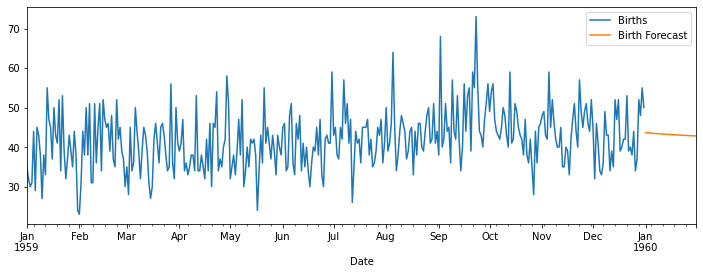

In [49]:
#Creating ARIMA Model
ARMA_model_forecast = ARMA(data1['Births'], order=(1,1))
ARMA_result_forecast = ARMA_model_forecast.fit()

#Forecasting on the model for next month
ARMA_pred_forecast = ARMA_result_forecast.predict(start = len(data1), end = len(data1)+30)

#Plotting Forecast
data1['Births'].plot(figsize=(12,4),label='Births',legend = True);
ARMA_pred_forecast.plot(label = 'Birth Forecast',legend = True);

# Creating ARIMA model on Trade Inventories

## Loading Data

In [51]:
#Loading Trade Inventories Data
data2 = pd.read_csv('C:/Users/bhavi/OneDrive/Desktop/Data/Time_Series_Data/TradeInventories.csv', 
                    index_col='Date', 
                    parse_dates=True)
data2.index.freq = 'MS'

## Checking the data

In [52]:
#Checking data
data2

,Inventories
Date,
1997-01-01,1301161
1997-02-01,1307080
1997-03-01,1303978
1997-04-01,1319740
1997-05-01,1327294
...,...
2018-08-01,2127170
2018-09-01,2134172
2018-10-01,2144639


Observations:
1. 22 years consist of 264 months.
2. 22*12=264

## Visualizing the data

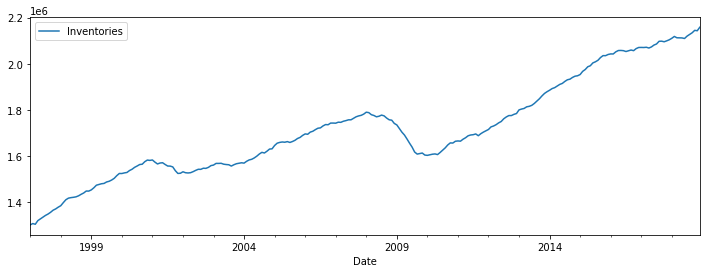

In [19]:
#Plotting data
data2.plot(figsize = (12,4));

Observation:
- As per the plot, data have trend but not sure about seasonality.
- The data is not look stationary. Lets We check through dicky fuller test.

## Checking stationarity through dicky fuller test

In [56]:
#Performing dickyfuller test to checkk whether the data are stationary or not
DICKY_FULLER_TEST(data2['Inventories'])

Dicky Fuller Test Summary:
1. ADFT Statistics: -0.08768390982064632
2. P-value        : 0.9506515302298976
3. Lags           : 5
4. Observations   : 258
5. Critical Values:
                   1% => -3.455952927706342
                   5% => -2.8728086526320302
                   10% => -2.572774990685656
6.Test conclusion from p-value :
  It is not a stationary
7.Test conclusion from critical value :
  It is not a stationary


Observation:
- As per the dicky fuller test, The data is not stationary We should make it as a stationary through differencing the data.

## Computing first order differencing

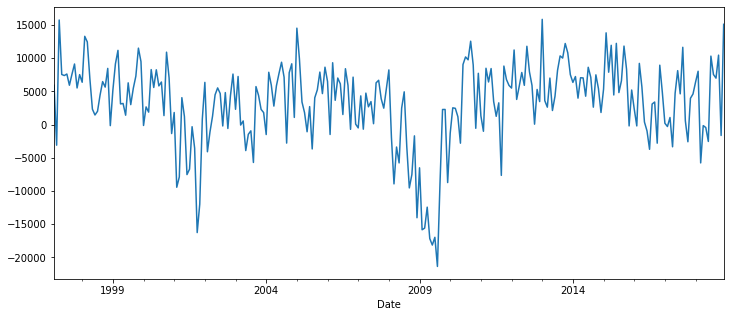

In [58]:
#Computing first order differencing
data2['Diff_1'] = diff(data2['Inventories'], k_diff=1)

#Dropping NA
data2.dropna(inplace=True)

#Plotting data
data2['Diff_1'].plot(figsize=(12,5));

## Checking stationarity through dicky fuller test on first order differencing

In [59]:
#Performing dickyfuller test to checkk whether the data are stationary or not
DICKY_FULLER_TEST(data2['Diff_1'])

Dicky Fuller Test Summary:
1. ADFT Statistics: -3.4122493919348074
2. P-value        : 0.010548311489190386
3. Lags           : 4
4. Observations   : 258
5. Critical Values:
                   1% => -3.455952927706342
                   5% => -2.8728086526320302
                   10% => -2.572774990685656
6.Test conclusion from p-value :
  It is a stationary
7.Test conclusion from critical value :
  It is not a stationary


Observation:
- As per dicky fuller test, it shows stationary.

## Seasonal decomposition of the data

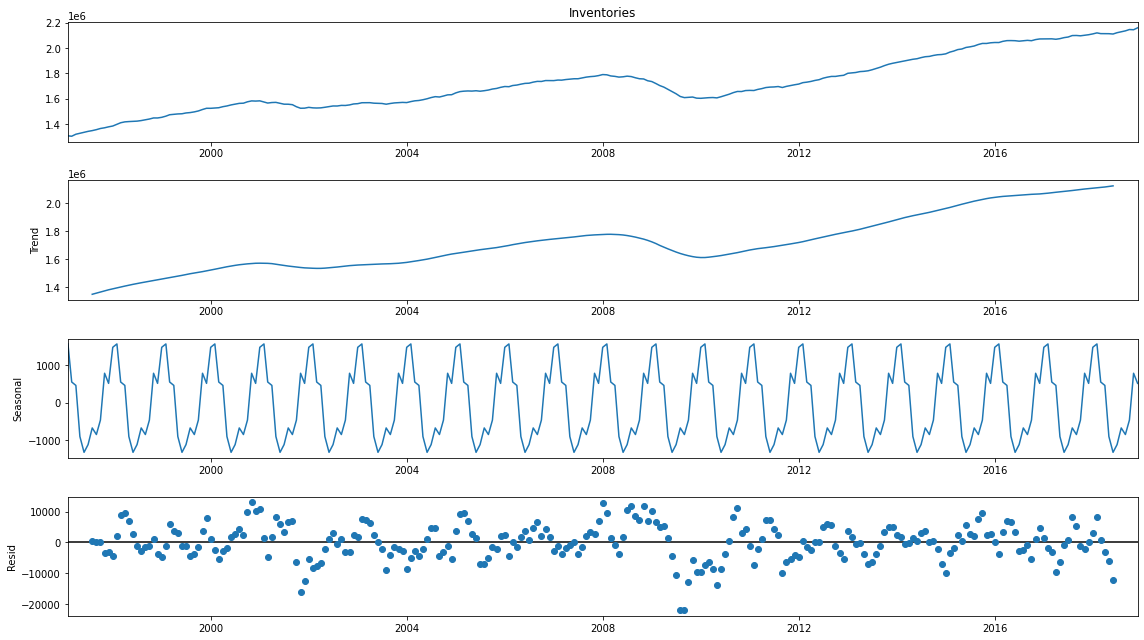

In [60]:
#Decompose the data
decompose = seasonal_decompose(data2['Inventories'], model = 'add')
plt.rcParams["figure.figsize"] = (16, 9)
decompose.plot();

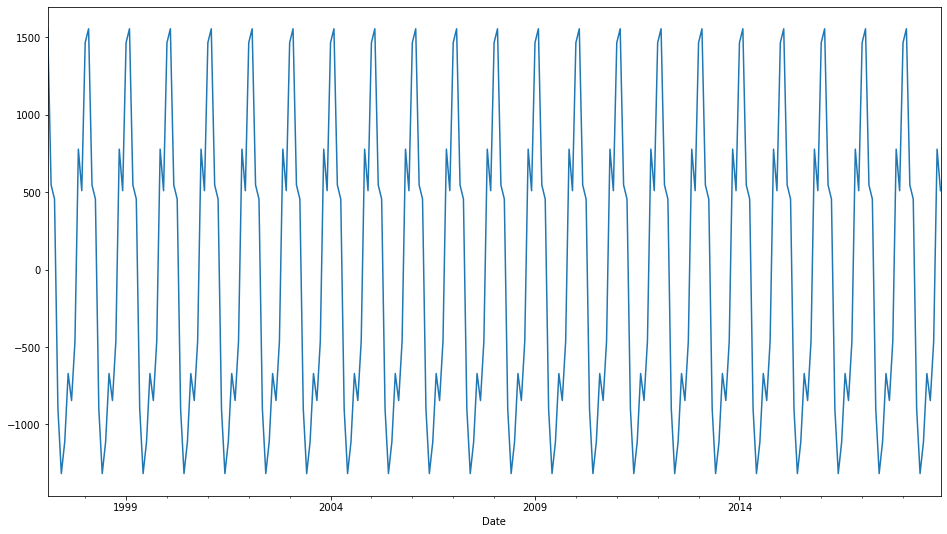

In [61]:
#Creating seasonality plot
decompose.seasonal.plot();

Observation:
- As per the decomposition plot, There is a trend in the data.
- It has a yearwise seasonality.

## Identifying AR and MA through ACF & PACF Plot

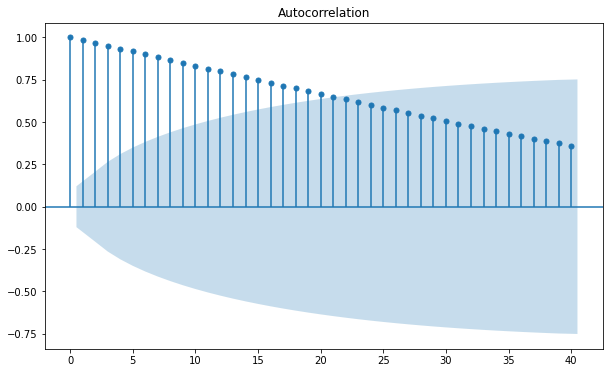

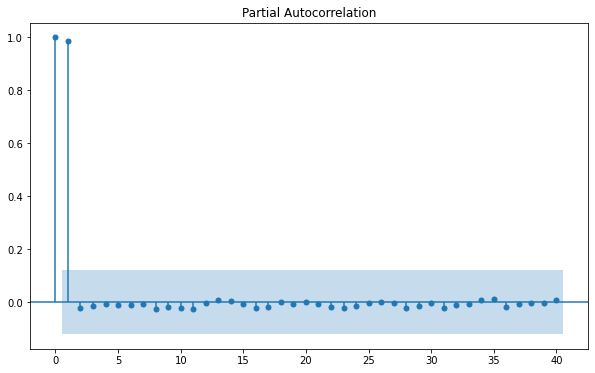

In [62]:
#Creating ACF for finding order for MA
plt.rcParams["figure.figsize"] = (10,6)
plot_acf(data2['Inventories'], lags=40);

#Creating PACS
plot_pacf(data2['Inventories'], lags=40);

Observation:
- As per the PACF plot, from first order it has geometrical decay.
- AS per the ACF plot, for MA term it has 1 significant order.

## Identifying AR, I, & MA term through Auto ARIMA

In [66]:
#Performing auto arima
auto_arima(data2['Inventories'], 
           seasonal=False, 
           trace=True,
           n_jobs=-1,).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5348.746, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5328.534, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5383.943, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5332.260, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5388.952, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5358.890, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.949 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  263
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2662.267
Date:                Mon, 29 Mar 2021   AIC                           5328.534
Time:                        19:55:57   BIC                           5335.671
Sample:                             0   HQIC                          5331.403
                                - 263                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3248.2252    472.070      6.881      0.000    2322.986    4173.465
sigma2      3.922e+07   2.97e+06     13.208      0.000    3.34e+07     4.5e+07
===================================================================================
Ljung-Box (L1) (Q):                  82.90   Jarque-Bera (JB):                98.95
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -1.14
Prob(H) (two-sided):                  0.35   Kurtosis:                         4.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Observation:
- As per the Auto ARIMA, the AR,I & MA term showing (0,1,0). However, We will take (1,1,1) order.

## Splitting data into train and test

In [67]:
#Train and test the data
train = data2[:252]
test = data2[252:]
train.shape, test.shape

((252, 2), (11, 2))

## Creating ARIMA Model with AR=1, I=1 & MA=1 order and Predicting on test data

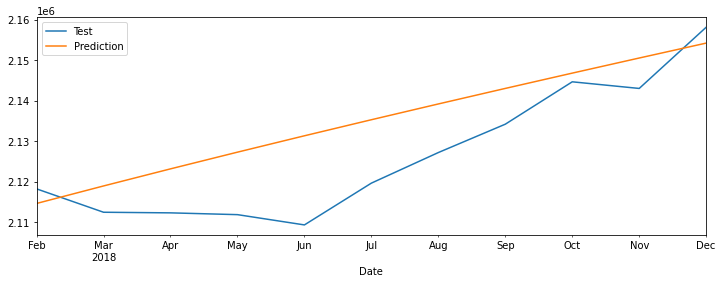

In [79]:
#Creating ARIMA model
ARIMA_model = ARIMA(train['Inventories'], order=(1,1,1))
ARIMA_result = ARIMA_model.fit()

#Prediction on the model
ARIMA_pred = ARIMA_result.predict(start=len(train), end =len(train)+len(test)-1, typ = 'levels')

#Plotting Actual vs Prediction
test['Inventories'].plot(figsize=(12,4), label ='Test',legend = True);
ARIMA_pred.plot(label ='Prediction', legend = True);

## Evaluation performance of the model

In [69]:
#Computing RMSE
print('RMSE of Model 1:',rmse(test['Inventories'], ARIMA_pred))
print('Mean of Test Data:', test['Inventories'].mean())

RMSE of Model 1: 11438.893544848625
Mean of Test Data: 2126431.8181818184


## Experiementing the different order combination and checking result

In [77]:
#Experiementing the different order combination and checking result
ARIMA_combinations = [(1,1,1),(1,1,0),(0,1,1),(1,1,2),(2,1,1),(1,2,1),(2,1,2),(2,2,2),(3,1,1),(3,1,2),(3,1,3),
                     (4,1,1),(4,1,2),(4,1,3),(4,1,4)]

for c in ARIMA_combinations:
    ARIMA_model = ARIMA(train['Inventories'], c)
    ARIMA_result = ARIMA_model.fit()
    ARIMA_pred = ARIMA_result.predict(start = len(train), end = len(train)+len(test)-1, typ = 'levels')
    RMSE = rmse(test['Inventories'], ARIMA_pred)
    print(c, '=', RMSE, 'AIC:', ARIMA_result.aic)

(1, 1, 1) = 11438.893544848625 AIC: 4981.079086405335
(1, 1, 0) = 10747.1729720242 AIC: 4999.404190876451
(0, 1, 1) = 9251.65072757325 AIC: 5033.12454497951
(1, 1, 2) = 11123.55878965794 AIC: 4980.849559728382
(2, 1, 1) = 11330.035116853227 AIC: 4981.403855141346
(1, 2, 1) = 12202.789530654467 AIC: 4968.668921554938
(2, 1, 2) = 10466.831010275266 AIC: 4975.524940263034
(2, 2, 2) = 11203.32090033973 AIC: 4964.7342756928565
(3, 1, 1) = 10924.344895052409 AIC: 4981.798568132326
(3, 1, 2) = 10417.643849252163 AIC: 4977.232687566839


c:\users\bhavi\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


(3, 1, 3) = 10179.665648158178 AIC: 4979.349167121654
(4, 1, 1) = 11136.456479289312 AIC: 4983.683179669146


c:\users\bhavi\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


(4, 1, 2) = 10107.654790004923 AIC: 4979.24456110981


c:\users\bhavi\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


(4, 1, 3) = 10152.303555288188 AIC: 4973.333495473485
(4, 1, 4) = 10998.43533328566 AIC: 4973.1932231208775


c:\users\bhavi\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


## Forecasting on ARIMA

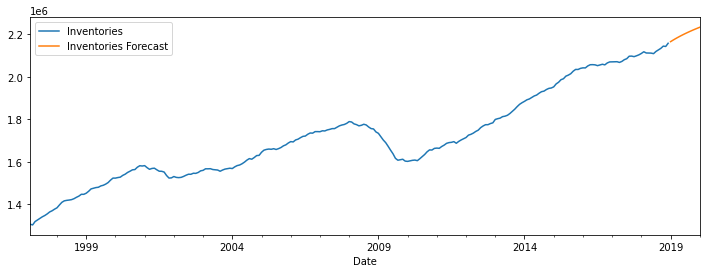

In [83]:
#Creating ARIMA Model
ARIMA_model_forecast = ARIMA(data2['Inventories'], order=(1,1,1))
ARIMA_result_forecast = ARIMA_model_forecast.fit()

#Forecasting on the model for next 12 month
ARIMA_pred_forecast = ARIMA_result_forecast.predict(start = len(data2), end = len(data2)+12, typ = 'levels')

#Plotting Forecast
data2['Inventories'].plot(figsize=(12,4),label='Inventories',legend = True);
ARIMA_pred_forecast.plot(label = 'Inventories Forecast',legend = True);